In [1]:
# http://www.robesafe.uah.es/personal/eduardo.romera/uah-driveset/

# http://www.robesafe.uah.es/personal/eduardo.romera/pdfs/Romera16itsc.pdf
# pdf contains description of data (what each column means)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import os

import folium
from geopy.distance import distance
# from datetime import datetime
from datetime import datetime, UTC

from ride_parser import UAHRideParser, RealRideParser
from app_data_parser import  generate_acc_from_vel, generate_jerk_from_acc
from PIL import Image

import matplotlib.dates as mdates

In [2]:
def get_df_without_outliers(df_to_describe, display_col_name, physical_qtty_name):
    df_to_describe = df_to_describe.rename(columns={display_col_name : physical_qtty_name})
    series_to_describe = df_to_describe[physical_qtty_name]

    # median_val = series_to_describe.median()
    first_quarter = series_to_describe.quantile(0.25)
    third_quarter = series_to_describe.quantile(0.75)

    quarter_dist = third_quarter - first_quarter

    lower_limit = first_quarter - 1.5 * quarter_dist
    upper_limit = third_quarter + 1.5 * quarter_dist

    filter_for_df = (series_to_describe >= lower_limit) & (series_to_describe <= upper_limit)

    return df_to_describe[filter_for_df]

In [3]:
def base_display_graph(df_to_display, display_col_name, physical_qtty_name, unit):
    fig, axs = plt.subplots(1, 1, figsize=(6.4, 3), layout='constrained')

    df_to_display = df_to_display.rename(columns={display_col_name : physical_qtty_name})

    series_to_display = df_to_display[physical_qtty_name]

    plt.plot("timestamp", physical_qtty_name, data=df_to_display)

    axs.grid(True)
    axs.set_ylabel("%s (%s)" % (physical_qtty_name, unit))
    axs.set_xlabel("Horário UTC")

    first_timestamp = df_to_display.iloc[0]["timestamp"]
    record_day_month_year_string = datetime.fromtimestamp(first_timestamp, UTC).strftime("%d/%m/%Y %H:%M")
    axs.set_title("Captura de %s em " % physical_qtty_name + record_day_month_year_string)

    min_val = series_to_display.min()
    max_val = series_to_display.max()
    median_val = series_to_display.median()

    plt.axhline(y=median_val, color="orange", linestyle="dashed", label="Mediana (%.2f)" % median_val) 
    plt.axhline(y=min_val, color="yellow", linestyle="dashed", label="Valor mínimo (%.2f)" % min_val) 
    plt.axhline(y=max_val, color="red", linestyle="dashed", label="Valor máximo (%.2f)" % max_val) 

    plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5),
            ncol=1, fancybox=True, shadow=True)

    plt.show()

In [4]:
def display_vel_graph(vel_df):
	base_display_graph(vel_df, "SPEED", "Velocidade", "m/s")

In [5]:
def display_acc_graph(acc_df):
	base_display_graph(acc_df, "acceleration", "Aceleração", "m/s^2")

In [6]:
def display_jerk_graph(jerk_df):
	base_display_graph(jerk_df, "jerk", "Arrancada", "m/s^3")

In [8]:
# # ride_root_dir = os.path.join("RealData", "Data_2023-11-03")
ride_root_dir = os.path.join("RealData", "Data_2023-11-20_pt2")
# # ride_root_dir = os.path.join("RealData", "FakeTest")
# # ride_root_dir = os.path.join("RealData", "Mercedes_25-11-2023")
# # ride_root_dir = os.path.join("RealData", "Ix35_Hyundai_25-11-2023")
# # ride_root_dir = os.path.join("RealData", "Agressivo_28-11-2023_traj1")
# # ride_root_dir = os.path.join("RealData", "Dados_com_millis")


real_ride = RealRideParser(root_dir=ride_root_dir)

latitudes = real_ride.gps_df["lat"]
longitudes = real_ride.gps_df["long"]

qtty_data = len(latitudes)

lat_longs = [(latitudes.iloc[i], longitudes.iloc[i]) for i in range(qtty_data)]

real_ride.accelerometer_df.head(3)

In [10]:
real_ride.generate_pdf_metrics()

In [11]:
map = real_ride.create_route_map()
real_ride.calculate_crime_stats(map)[0]

response <Response [200]>
Function 'create_obd_df' executed in 6.1886s
Function 'create_gps_df' executed in 1.2376s
Function 'create_accelerometer_df' executed in 15.9612s


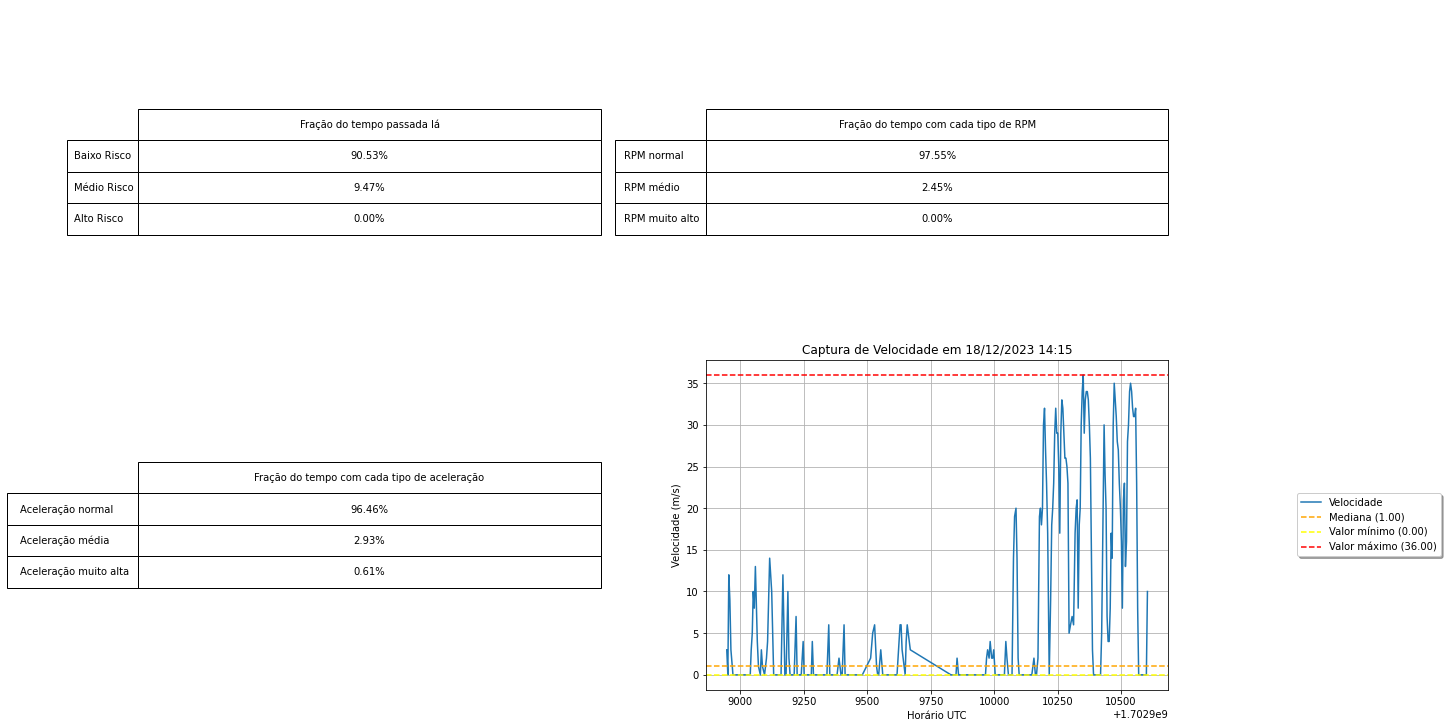

In [13]:
user_token = "arthurpfonseca@gmail.com"
date_beg = datetime.strptime("2023-12-18 21:20:00.000", "%Y-%m-%d %H:%M:%S.%f").__str__()
date_end = datetime.strptime("2024-12-18 22:19:59.999", "%Y-%m-%d %H:%M:%S.%f").__str__()

real_ride_database = RealRideParser(should_get_data_from_database=True, user_token=user_token, date_beg=date_beg, date_end=date_end)
real_ride_database.generate_pdf_metrics()

In [ ]:
pdf_bytes_io = real_ride.generate_pdf_metrics()
pdf_bytes_io.seek(0)

send_email("arthurpfonseca@gmail.com", pdf_bytes_io)


In [ ]:
real_ride.obd_data["ENGINE_RPM"]

In [ ]:
real_ride.generate_graph_for_bearing()

In [ ]:
real_ride.generate_graph_for_orientation()

In [ ]:
obd_data = real_ride.obd_data

vels_from_obd_df = obd_data["SPEED"]

# display_vel_graph(vels_from_obd_df)

In [ ]:
print(real_ride.get_acc_stats())
real_ride.gps_df
vels_from_gps_df = real_ride.create_velocity_from_gps_df()
# display_vel_graph(vels_from_gps_df.iloc[-150:])
# vels_from_gps_df.plot(x="timestamp", y="velocity")

In [ ]:
gps_timestamps = vels_from_gps_df["timestamp"]
obd_timestamps = vels_from_obd_df["timestamp"]

min_gps_time = gps_timestamps.min()
max_gps_time = gps_timestamps.max()

min_obd_time = obd_timestamps.min()
max_obd_time = obd_timestamps.max()

min_time_filter = max(min_gps_time, min_obd_time)
max_time_filter = min(max_gps_time, max_obd_time)

min_time_filter, max_time_filter

In [ ]:
filter_gps = (vels_from_gps_df["timestamp"] >= min_time_filter) & (vels_from_gps_df["timestamp"] <= max_time_filter)
filtered_vels_from_gps_df = vels_from_gps_df[filter_gps]

display_vel_graph(filtered_vels_from_gps_df)

filter_obd = (vels_from_obd_df["timestamp"] >= min_time_filter) & (vels_from_obd_df["timestamp"] <= max_time_filter)
filtered_vels_from_obd_df = vels_from_obd_df[filter_obd]

display_vel_graph(filtered_vels_from_obd_df)

In [ ]:
from scipy.interpolate import CubicHermiteSpline

xx = np.linspace(min_time_filter, max_time_filter, 1000)

# GPS
x_gps = filtered_vels_from_gps_df["timestamp"]
y_gps = filtered_vels_from_gps_df["SPEED"]
p_gps = CubicHermiteSpline(x=x_gps, y=y_gps, dydx=np.zeros_like(y_gps))  # interpolator   
plt.scatter(x_gps, y_gps, s=10, c="blue", marker="o", linewidth=1)

# plt.scatter(xx, p(xx), s=[1 for _ in range(len(xx))])
line, = plt.plot(xx, p_gps(xx), label="GPS")
line.set_color("blue")

# OBD
x_obd = filtered_vels_from_obd_df["timestamp"]
y_obd = filtered_vels_from_obd_df["SPEED"]
p_obd = CubicHermiteSpline(x=x_obd, y=y_obd, dydx=np.zeros_like(y_obd))  # interpolator   
plt.scatter(x_obd, y_obd, s=10, c="green", marker="o", linewidth=1)

line, = plt.plot(xx, p_obd(xx), label="OBD")
line.set_color("green")
   
# difference
difference_np_array = abs(p_obd(xx) - p_gps(xx))
mean_diff = difference_np_array.mean()
line, = plt.plot(xx, difference_np_array, label="Valor absoluto da diferença")
line.set_color("red")

plt.axhline(y=mean_diff, color="orange", linestyle="dashed", label="Média diferença") 

plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.ylabel("Velocidade (km/h)")
plt.xlabel("Horário UTC")
plt.title("Comparação entre velocidade obtida pelo OBD e pelas coordenadas do GPS")
mean_diff

In [ ]:
# obd_data = get_data_from_app()

# vels_from_obd_df = app_data["SPEED"]
# display_vel_graph(vels_from_obd_df)

# print(app_data["SPEED"])

In [ ]:
acc_from_android_df = real_ride.accelerometer_df[["timestamp", "remaining_acc_resultant"]].copy()
acc_from_android_df.rename(columns={"remaining_acc_resultant": "acceleration"}, inplace=True)

acc_from_obd_df = generate_acc_from_vel(vels_from_obd_df)

android_timestamps = acc_from_android_df["timestamp"]
obd_timestamps = acc_from_obd_df["timestamp"]

min_android_time = android_timestamps.min()
max_android_time = android_timestamps.max()

min_obd_time = obd_timestamps.min()
max_obd_time = obd_timestamps.max()

min_time_filter = max(min_android_time, min_obd_time)
max_time_filter = min(max_android_time, max_obd_time)

min_time_filter, max_time_filter

In [ ]:
filter_android = (acc_from_android_df["timestamp"] >= min_time_filter) & (acc_from_android_df["timestamp"] <= max_time_filter)
filtered_acc_from_android_df = acc_from_android_df[filter_android].drop_duplicates(subset=["timestamp"])

display_acc_graph(filtered_acc_from_android_df.iloc[0:20])

filter_obd = (acc_from_obd_df["timestamp"] >= min_time_filter) & (acc_from_obd_df["timestamp"] <= max_time_filter)
filtered_acc_from_obd_df = acc_from_obd_df[filter_obd]

display_acc_graph(filtered_acc_from_obd_df.iloc[0:20])

In [ ]:
jerk_from_android_df = generate_jerk_from_acc(acc_from_android_df)
jerk_from_obd_df = generate_jerk_from_acc(acc_from_obd_df)

android_timestamps = jerk_from_android_df["timestamp"]
obd_timestamps = jerk_from_obd_df["timestamp"]

min_android_time = android_timestamps.min()
max_android_time = android_timestamps.max()

min_obd_time = obd_timestamps.min()
max_obd_time = obd_timestamps.max()

min_time_filter = max(min_android_time, min_obd_time)
max_time_filter = min(max_android_time, max_obd_time)

min_time_filter, max_time_filter

In [ ]:
filter_android = (jerk_from_android_df["timestamp"] >= min_time_filter) & (jerk_from_android_df["timestamp"] <= max_time_filter)
filtered_jerk_from_android_df = jerk_from_android_df[filter_android].drop_duplicates(subset=["timestamp"])

display_jerk_graph(filtered_jerk_from_android_df.iloc[0:100])

filter_obd = (jerk_from_obd_df["timestamp"] >= min_time_filter) & (jerk_from_obd_df["timestamp"] <= max_time_filter)
filtered_jerk_from_obd_df = jerk_from_obd_df[filter_obd]

display_jerk_graph(filtered_jerk_from_obd_df.iloc[0:100])

In [ ]:
from scipy.interpolate import CubicHermiteSpline

xx = np.linspace(min_time_filter, max_time_filter, 1000)

# Android
x_android = filtered_acc_from_android_df["timestamp"]
y_android = filtered_acc_from_android_df["acceleration"]
p_android = CubicHermiteSpline(x=x_android, y=y_android, dydx=np.zeros_like(y_android))  # interpolator   
plt.scatter(x_android, y_android, s=10, c="blue", marker="o", linewidth=1)

# plt.scatter(xx, p(xx), s=[1 for _ in range(len(xx))])
line, = plt.plot(xx, p_android(xx), label="Android")
line.set_color("blue")

# OBD
x_obd = filtered_acc_from_obd_df["timestamp"]
y_obd = filtered_acc_from_obd_df["acceleration"]
p_obd = CubicHermiteSpline(x=x_obd, y=y_obd, dydx=np.zeros_like(y_obd))  # interpolator   
plt.scatter(x_obd, y_obd, s=10, c="green", marker="o", linewidth=1)

line, = plt.plot(xx, p_obd(xx), label="OBD")
line.set_color("green")
   
# difference
difference_np_array = abs(p_obd(xx) - p_android(xx))
mean_diff = difference_np_array.mean()
line, = plt.plot(xx, difference_np_array, label="Valor absoluto da diferença")
line.set_color("red")

plt.axhline(y=mean_diff, color="orange", linestyle="dashed", label="Média diferença") 

plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.ylabel("Aceleração (m/s^2)")
plt.xlabel("Horário UTC")
plt.title("Comparação entre aceleração obtida pelos acelerômetros e pelas coordenadas GPS do Android")
mean_diff

In [ ]:
from scipy.interpolate import CubicHermiteSpline

xx = np.linspace(min_time_filter, max_time_filter, 1000)

# GPS
x_gps = filtered_vels_from_gps_df["timestamp"]
y_gps = filtered_vels_from_gps_df["SPEED"]
p_gps = CubicHermiteSpline(x=x_gps, y=y_gps, dydx=np.zeros_like(y_gps))  # interpolator   
plt.scatter(x_gps, y_gps, s=10, c="blue", marker="o", linewidth=1)

# plt.scatter(xx, p(xx), s=[1 for _ in range(len(xx))])
line, = plt.plot(xx, p_gps(xx), label="GPS")
line.set_color("blue")

# OBD
x_obd = filtered_vels_from_obd_df["timestamp"]
y_obd = filtered_vels_from_obd_df["SPEED"]
p_obd = CubicHermiteSpline(x=x_obd, y=y_obd, dydx=np.zeros_like(y_obd))  # interpolator   
plt.scatter(x_obd, y_obd, s=10, c="green", marker="o", linewidth=1)

line, = plt.plot(xx, p_obd(xx), label="OBD")
line.set_color("green")
   
# difference
difference_np_array = abs(p_obd(xx) - p_gps(xx))
mean_diff = difference_np_array.mean()
line, = plt.plot(xx, difference_np_array, label="Valor absoluto da diferença")
line.set_color("red")

plt.axhline(y=mean_diff, color="orange", linestyle="dashed", label="Média diferença") 

plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.ylabel("Velocidade (km/h)")
plt.xlabel("Horário UTC")
plt.title("Comparação entre velocidade obtida pelo OBD e pelas coordenadas do GPS")
mean_diff

In [ ]:
start_lat_long = lat_longs[0]
end_lat_long = lat_longs[-1]

mean_lat = latitudes.mean()
mean_long = longitudes.mean()

start_lat_long, end_lat_long, qtty_data

In [ ]:
map = folium.Map(location=[mean_lat, mean_long], zoom_start=14, control_scale=True)

folium.Marker(start_lat_long, popup="start").add_to(map)
folium.Marker(end_lat_long, popup="end").add_to(map)

In [ ]:
for i in range(qtty_data - 1):
	location_1 = lat_longs[i]
	location_2 = lat_longs[i + 1]

	folium.PolyLine([location_1, location_2],
					color='red',
					weight=5,
					opacity=0.4).add_to(map)

real_ride.create_route_map()

In [ ]:
accelerometer_df = real_ride.accelerometer_df
last_timestamp = accelerometer_df.timestamp.iloc[-1] # .timestamp()
delta_time_size = 100 	# 100 s
frame_granularity = 10 	# 50 s
qtty_frames = (last_timestamp - delta_time_size) // frame_granularity

filtered_accelerations_df = accelerometer_df

print("last_timestamp", last_timestamp)
print("qtty_frames", qtty_frames)
print("last_timestamp", last_timestamp)

qtty_frames = min(qtty_frames, 100)

# generate_3_axis_acc_graph(accelerometer_df, frame_granularity, delta_time_size, 0)

for i in range(10): #qtty_frames):
    real_ride.generate_3_axis_acc_graph(frame_granularity, delta_time_size, i)


In [ ]:
# vels_from_gps_no_outliers_df = get_df_without_outliers(filtered_vels_from_gps_df, "SPEED", "Velocidade")
# vels_from_obd_no_outliersdf = get_df_without_outliers(filtered_vels_from_obd_df, "SPEED", "Velocidade")

acc_from_android_no_outliers_df = get_df_without_outliers(filtered_acc_from_android_df, "acceleration", "Aceleração")
acc_from_obd_no_outliers_df = get_df_without_outliers(filtered_acc_from_obd_df, "acceleration", "Aceleração")

jerk_from_android_no_outliers_df = get_df_without_outliers(filtered_jerk_from_android_df, "jerk", "Arrancada")
jerk_from_obd_no_outliers_df = get_df_without_outliers(filtered_jerk_from_obd_df, "jerk", "Arrancada")

In [ ]:
# display_vel_graph(vels_from_gps_no_outliers_df)
# display_vel_graph(vels_from_obd_no_outliers_df)

display_acc_graph(acc_from_android_no_outliers_df)
display_acc_graph(acc_from_obd_no_outliers_df)

display_jerk_graph(jerk_from_android_no_outliers_df)
display_jerk_graph(jerk_from_obd_no_outliers_df)

In [ ]:
# real_ride.calculate_acc_stats_near_stop()

Objetivos:
- [x] Gerar mapa com a rota feita por cada um dos motoristas
- [] Sincronizar vídeo com eventos de aceleração

In [ ]:
# ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151110175712-16km-D1-NORMAL1-SECONDARY")
ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151111125233-24km-D1-AGGRESSIVE-MOTORWAY")

ride = UAHRideParser(ride_root_dir)

# col_names = [str(i) for i in range(13)]
# col_names = ["timestamp", "speed", "lat", "long", "altitude", "vert accuracy", "horiz accuracy", "course", "difcourse", "?1", "?2", "?3", "?4"]
# pd.read_csv(gps_file_path, sep=" ", names=col_names)

ride.gps_df
ride.accelerometer_df

In [ ]:
accelerometer_df = ride.accelerometer_df
oldest_timestamp = int(accelerometer_df.timestamp.iloc[-1])
delta_time_size = 20
frame_granularity = 1
qtty_frames = (oldest_timestamp - delta_time_size) // frame_granularity

print("qtty_frames", qtty_frames)
print("oldest_timestamp", oldest_timestamp)

for i in range(10): #qtty_frames):
    with ProcessPoolExecutor(max_workers=10) as executor:
        future = executor.submit(ride.foo, accelerometer_df, frame_granularity, delta_time_size, i)

    # print(future.result())

# plt.show()
# RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

In [ ]:
# fig, axs = plt.subplots(ncols=1, nrows=4)

# accelerometer_df = ride.accelerometer_df
# accelerometer_df = accelerometer_df[accelerometer_df.timestamp < 20]
# filtered_acc_x = accelerometer_df["filtered_acc_x"]
# filtered_acc_y = accelerometer_df["filtered_acc_y"]
# filtered_acc_z = accelerometer_df["filtered_acc_z"]
# acc_resultant = accelerometer_df["acc_resultant"]
# timestamp = accelerometer_df["timestamp"]

# # axs[0].scatter(timestamp, filtered_acc_x, s=0.1)
# axs[0].plot(timestamp, filtered_acc_x) #, "-o")
# axs[0].set_title("filtered_acc_x")

# axs[1].plot(timestamp, filtered_acc_y)
# axs[1].set_title("filtered_acc_y")

# axs[2].plot(timestamp, filtered_acc_z)
# axs[2].set_title("filtered_acc_z")

# axs[3].plot(timestamp, acc_resultant)
# axs[3].set_title("acc_resultant")

# fig.tight_layout()

# plt.show()

In [ ]:
# import numpy as np
# from scipy.spatial.distance import euclidean

# from fastdtw import fastdtw

# # x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
# # y = np.array([[2,2], [3,3], [4,4]])

# x = [tuple(el) for _, el in vels_from_obd_df.iterrows()][-107:]
# y = [tuple(el) for _, el in vels_from_gps_df.iterrows()][-107:]

# distance, path = fastdtw(x, y, dist=euclidean)
# print(distance, path)

In [ ]:
# def display_vel_graph(vel_df):
#     #  https://stackoverflow.com/questions/75566545/problem-with-matplotlib-date-formatting-and-conversion-from-epoch-time-overlowe
# 	plt.rcParams['date.converter'] = 'concise'

# 	fig, axs = plt.subplots(1, 1, figsize=(6.4, 3), layout='constrained')
#     # common to all three:
#     # for ax in axs:
# 	# ax[1].plot(time.astype('datetime64[s]'), y)

# 	# ax.plot('date', 'adj_close', data=data)
# 	plt.plot("timestamp", "SPEED", data=vel_df)
# 	# Major ticks every half year, minor ticks every second,
# 	# axs.xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(60)))
# 	# axs.xaxis.set_minor_locator(mdates.MinuteLocator())
# 	axs.grid(True)
# 	axs.set_ylabel("Velocidade (km/h)")
# 	axs.set_xlabel("Horário UTC")

# 	# ax = axs[0]
# 	first_timestamp = vel_df.iloc[0]["timestamp"]
# 	record_day_month_year_string = datetime.utcfromtimestamp(first_timestamp).strftime("%d/%m/%Y")
# 	axs.set_title("Captura " + record_day_month_year_string)

# 	# axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# 	# # Rotates and right-aligns the x labels so they don't crowd each other.
# 	# for label in axs.get_xticklabels(which='major'):
# 	# 	label.set(rotation=30, horizontalalignment='right')

# 	plt.show()

In [ ]:
imgs = ride.generate_acc_sub_graph()

# im = Image.open(next(imgs))
# im.show(title="My Image")

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.animation as animation

# import numpy
# from PIL import Image

# n = 20

# img = [] # some array of images
# for i in range(n):
# 	imarray = numpy.random.rand(100,100,3) * 255
# 	im = Image.fromarray(imarray.astype('uint8')).convert('RGBA')
# 	img.append(im)

# frames = [] # for storing the generated images
# fig = plt.figure()
# for i in range(n):
# 	frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

# ani = animation.ArtistAnimation(fig, frames, blit=True)

# writergif = animation.PillowWriter(fps=1)
# ani.save('movie.gif', writer=writergif)
# plt.show()

In [ ]:
import io
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.figure()
plt.plot([1, 2])

img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')

im = Image.open(img_buf)
im.show(title="My Image")

img_buf.close()

In [ ]:
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# Example image data in BytesIO object
# image_data = b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x02\x00\x00\x00\x02\x08\x06\x00\x00\x00\x1f\xf3\x0e\x82\x00\x00\x00\x0bIDATx\x9c\xed\xc1\x01\r\x00\x00\x00\xc2\x00\x01\x10\x00\x00\x00\x00IEND\xaeB`\x82'

# Create BytesIO object
image_stream = BytesIO(image_data)

# Open image using PIL
image = Image.open(image_stream)

# Create a subplot
fig, ax = plt.subplots()

# Display the image on the subplot
ax.imshow(image)

# Show the plot
plt.show()


In [ ]:
import folium
# import mplleaflet
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# Criar um mapa Folium
map_center = [-23.5505, -46.6333]  # Exemplo de coordenadas para São Paulo, Brasil
folium_map = folium.Map(location=map_center, zoom_start=12)

# Adicionar alguns marcadores ou outros elementos ao mapa Folium, se necessário
folium.Marker(location=[-23.5505, -46.6333], popup='São Paulo').add_to(folium_map)

# Converter o mapa Folium diretamente em um gráfico Matplotlib
fig, ax = plt.subplots()
# mplleaflet.display(fig=fig, crs=folium_map.crs, tiles='cartodb_positron', close_fig=False)

# Salvar o gráfico em um BytesIO object
image_data = folium_map._to_png(5)
image_stream = BytesIO(image_data)
# fig.savefig(image_stream, format='png')
image_stream.seek(0)  # Resetar a posição do stream para o início

# Abrir a imagem usando PIL
image = Image.open(image_stream)

# Criar um subplot
fig, ax = plt.subplots()

# Exibir a imagem no subplot
ax.imshow(image)

# Mostrar o gráfico
plt.show()


In [ ]:
import folium
from io import BytesIO

# Criar um mapa Folium
map_center = [-23.5505, -46.6333]  # Exemplo de coordenadas para São Paulo, Brasil
folium_map = folium.Map(location=map_center, zoom_start=12)

# Obter o conteúdo HTML do mapa
html_content = folium_map.get_root().render()

# Salvar o conteúdo HTML em BytesIO
bytes_io = BytesIO(html_content.encode())

# Resetar a posição do stream para o início
bytes_io.seek(0)

# Exemplo de uso do BytesIO
print(bytes_io.read().decode())


In [ ]:
import folium
from io import BytesIO
from PIL import Image

# Criar um mapa Folium
map_center = [-23.5505, -46.6333]  # Exemplo de coordenadas para São Paulo, Brasil
folium_map = folium.Map(location=map_center, zoom_start=12)

# Salvar o mapa como uma imagem localmente (por padrão, é salvo como 'map.html')
# map_path = 'map.png'
# folium_map.save(map_path)
img_data = folium_map._to_png(5)
img = Image.open(io.BytesIO(img_data))

# Ler a imagem em um objeto BytesIO
# with open(map_path, 'rb') as file:
#     bytes_io = BytesIO(file.read())

# Resetar a posição do stream para o início
bytes_io.seek(0)

# Exemplo de uso do BytesIO (opcional)
print(bytes_io.read())  # Você pode remover esta linha se não precisar usar o conteúdo do BytesIO
